## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br>
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br>

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

# Подготовка

In [1]:
import re
import requests
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates


"""
https://oauth.vk.com/oauth/authorize?client_id=51511632&display=page&redirect_uri=http://oauth.vk.com/blank.html&scope=all&response_type=token&slogin_h=ec08891397b8d4e4a8.fe24a1a6a6cc459efe&__q_hash=6f89635878dc9d8dd4b35aa21496d9e3
"""

vk_token = 'vk1.a.0nkfRf8MQGcqta1Snqm6GPQnv9uD-6yMZBX_98DGTHI5q6mLNr9V5p0WXxh5fpZf7CZz382Rhzq34kxTcGzW6KCQrSsRAkb6o2xw1dsz94NpBU8jz5aGmDG-QTm-GxNHw6DvMHBH5efW2kh17Z3ehAsTz8g9R-tYWW21B-Vpjlu25GtzxpvN3LC-Lxh7PaSs'

conn = sqlite3.connect('database.db')

Загружаем посты и информацию о лайкнувших пользователях.
Для начала рассматриваются посты с 2018-го года.

In [1]:
def calc_age(row):
    """Функция для вычисления возраста"""
    date_list = str(row['bdate']).split('.')
    if len(date_list) == 3:
        return datetime.now().year - int(date_list[-1])
    else:
        return None


def get_users_stat(post):

    post_id = post['id']

    # запрашиваем список пользователей, лайкнувших пост
    url = f'https://api.vk.com/method/'\
          f'likes.getList?access_token={vk_token}'\
          f'&type=post&owner_id=-66669811&item_id={post_id}&v=5.92'
    response = requests.get(url).json()
    users = response['response']['items']
    user_str = str(users).replace('[', '').replace(']', '')

    # запрашиваем информацию об этих пользователях
    url = f'https://api.vk.com/method/'\
          f'users.get?access_token={vk_token}'\
          f'&fields=bdate,city,country,sex'\
          f'&user_ids={user_str}&v=5.92'
    response = requests.get(url).json()

    # из ответа формируем датафрейм и добавляем в БД
    users_df = pd.json_normalize(response['response'])

    if len(users_df) > 0:
        # если ни у кого из лайкнувших не указан возраст/город/страна,
        # заполняем столбец значением None
        users_df = users_df.reindex(columns=['sex', 'bdate', 'city.title', 'country.title'])

    users_df['post_id'] = post_id
    users_df['age'] = users_df.apply(lambda row: calc_age(row), axis=1)
    users_df.to_sql('users_activity', conn, if_exists='append', index=False)
    print(f'{offset=}, {post_id=}, {post["date"]=}')


def get_tag(post):
    tags = re.findall(r'#\w+', post['text'])
    return str(tags).replace('[', '').replace(']', '') if tags else None


# id паблика для анализа
public_id = '-66669811'

# загружаем с первого поста по 100 постов - максимум за раз
offset = 0
count = 100

collect_statistics = True

# загружаем посты до указанной даты
until_date = datetime(2018, 1, 1)

while True:
    # отправляем запрос и сохраняем ответ в виде словаря
    url = f'https://api.vk.com/method/wall.get?access_token={vk_token}'\
          f'&owner_id={public_id}'\
          f'&count={count}'\
          f'&offset={offset}'\
          f'&v=5.92'
    response = requests.get(url).json()

    # преобразуем словарь в датафрейм,
    # нормализуем элементы словаря, чтобы получилась "плоская" таблица
    df = pd.json_normalize(response['response']['items'])
    df = df[['id', 'date', 'text', 'comments.count', 'likes.count', 'post_source.type',
             'reposts.count', 'reposts.user_reposted', 'views.count']]
    df.rename(columns={'id': 'post.id'})

    # меняем формат даты
    df['date'] = df.apply(lambda x: datetime.fromtimestamp(x['date']), axis=1)

    # теги добавляем в отдельный столбец
    df['tag'] = df.apply(lambda row: get_tag(row), axis=1)

    # если добрались до нужной даты - останавливаемся
    date = df['date'].min()
    if date < until_date:
        # добавляем полученные посты до until_date в базу данных
        df = df[df['date'] > until_date]
        if collect_statistics:
            df.apply(lambda post: get_users_stat(post), axis=1)
        df.to_sql('posts', conn, if_exists='append', index=False)
        offset += len(df[df['date'] > until_date])
        break

    # иначе - загружаем еще count постов
    else:
        # добавляем все посты в базу данных
        if collect_statistics:
            df.apply(lambda post: get_users_stat(post), axis=1)
        df.to_sql('posts', conn, if_exists='append', index=False)
        offset += count
    print(f'Загружены посты с {offset + 1 - count} по {offset + 1}... '
          f'Загружены посты до {date}')

print(f'Все посты до {date} выгружены. Всего {offset} постов')

offset=0, post_id=278861, post["date"]=Timestamp('2022-12-16 19:00:19')
offset=0, post_id=279630, post["date"]=Timestamp('2023-01-04 12:30:00')
offset=0, post_id=279617, post["date"]=Timestamp('2023-01-03 11:50:51')
offset=0, post_id=279606, post["date"]=Timestamp('2023-01-02 12:05:00')
offset=0, post_id=279587, post["date"]=Timestamp('2022-12-31 12:00:03')
offset=0, post_id=279576, post["date"]=Timestamp('2022-12-30 11:00:00')
offset=0, post_id=279569, post["date"]=Timestamp('2022-12-29 11:30:00')
offset=0, post_id=279474, post["date"]=Timestamp('2022-12-28 13:15:00')
offset=0, post_id=279463, post["date"]=Timestamp('2022-12-28 10:23:50')
offset=0, post_id=279460, post["date"]=Timestamp('2022-12-27 19:02:20')
offset=0, post_id=279246, post["date"]=Timestamp('2022-12-27 11:01:00')
offset=0, post_id=279229, post["date"]=Timestamp('2022-12-26 14:12:25')
offset=0, post_id=279228, post["date"]=Timestamp('2022-12-26 10:38:01')
offset=0, post_id=279060, post["date"]=Timestamp('2022-12-23 13:

# Динамика сообщества
Просмотры, лайки и репосты за все время.

In [51]:
query = """
SELECT date, "views.count", "likes.count", "reposts.count", "comments.count"
FROM posts
"""

data = pd.read_sql(query, conn, parse_dates=['date'])
data = data.resample('w', on='date').median().reset_index()
data.head()

,date,views.count,likes.count,reposts.count,comments.count
0,2018-01-21,8104.0,46.0,3.0,6.0
1,2018-01-28,6913.0,22.0,2.0,2.0
2,2018-02-04,6866.0,57.0,10.0,0.0
3,2018-02-11,6185.0,24.0,1.5,0.5
4,2018-02-18,8134.0,18.0,1.0,3.0


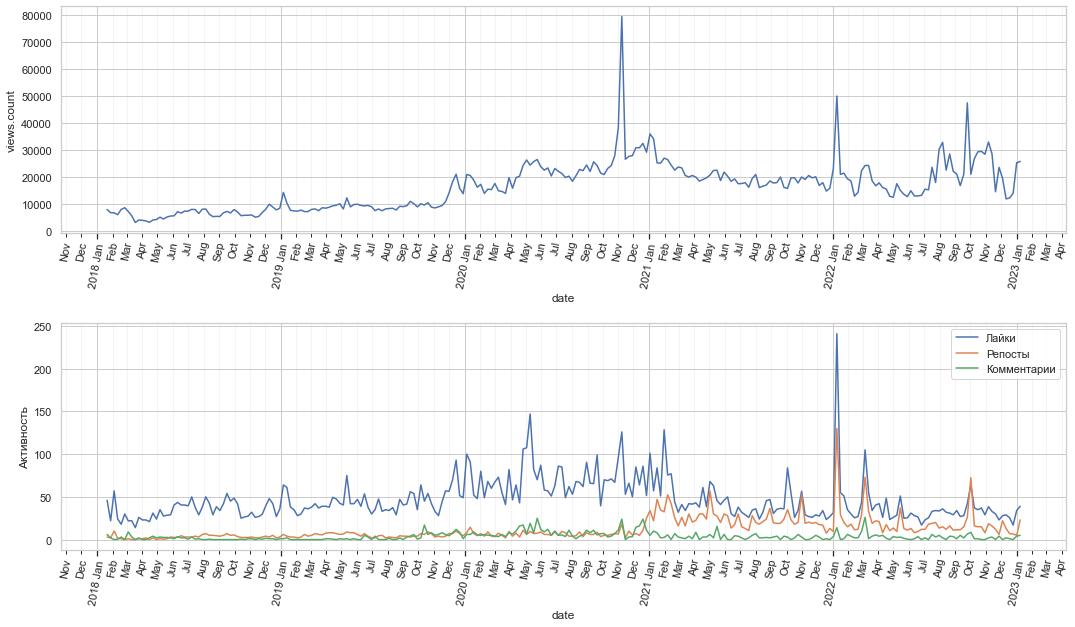

In [54]:
fig, axs = plt.subplots(nrows=2, figsize=(18, 10))
sns.set(style='whitegrid', rc={"xtick.bottom": True})

sns.lineplot(data=data, x='date', y='views.count', ax=axs[0])
sns.lineplot(data=data, x='date', y='likes.count', ax=axs[1], label='Лайки')
sns.lineplot(data=data, x='date', y='reposts.count', ax=axs[1], label='Репосты')
sns.lineplot(data=data, x='date', y='comments.count', ax=axs[1], label='Комментарии')

for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))

    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

    ax.tick_params(axis='x', which='both', rotation=80)
    ax.grid(True, which='minor', alpha=0.2)

axs[1].set_ylabel('Активность')

plt.subplots_adjust(hspace=0.4)
plt.show()

1. С начала 2020 года активность выросла - это наиболее интересный участок для дальнейшего анализа.
2. Активность пользователей была наивысшей в 2020 году, при этом сохранялась положительная динамика роста.
3. На графике видны выбросы. Рассмотрим посты, которые их обеспечили:

In [11]:
print('Топ-5 постов по количеству просмотров')
display(pd.read_sql('SELECT * FROM posts ORDER BY "views.count" DESC LIMIT 5', conn, parse_dates=['date']))

print('Топ-5 постов по количеству лайков')
display(pd.read_sql('SELECT * FROM posts ORDER BY "likes.count" DESC LIMIT 5', conn, parse_dates=['date']))

print('Топ-5 постов по количеству комментариев')
display(pd.read_sql('SELECT * FROM posts ORDER BY "comments.count" DESC LIMIT 5', conn, parse_dates=['date']))

Топ-5 постов по количеству просмотров


,id,date,text,comments.count,likes.count,post_source.type,reposts.count,reposts.user_reposted,views.count,tag
0,24338,2018-05-23 16:00:11,"Хей-хей, ребята. Мы тут с Лентачом запустили с...",7,917,vk,18,0,1744101,'#test'
1,202013,2021-08-26 10:30:02,Есть разные способы узнать больше о Skillbox. ...,4,246,vk,104,0,1075705,None
2,215343,2021-11-01 13:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",453,1466,vk,2182,0,210802,None
3,209288,2021-09-28 13:59:24,Научитесь создавать сценарии и постройте карье...,48,211,vk,128,0,165950,None
4,25179,2018-06-14 14:00:12,Работа современного дизайнера уже давно не сво...,7,194,vk,18,0,145413,'#read'


Топ-5 постов по количеству лайков


,id,date,text,comments.count,likes.count,post_source.type,reposts.count,reposts.user_reposted,views.count,tag
0,215343,2021-11-01 13:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",453,1466,vk,2182,0,210802,None
1,30954,2019-01-25 13:00:13,,2,1113,vk,1,0,9218,None
2,251053,2022-07-12 17:39:28,"Мы в Skillbox верим, что каждый достоин второг...",141,1018,api,282,0,117894,'#Жизньпосле'
3,32760,2019-04-07 10:30:00,"Ловите скорее 8 вебинаров, посвященных социаль...",7,978,vk,283,0,73769,None
4,58762,2020-05-06 12:20:16,"Срочно нужна анимация в соцсети, а у дизайнера...",20,946,api,178,0,72536,"'#В_закладки_Skillbox', '#Skillbox_дизайн'"


Топ-5 постов по количеству комментариев


,id,date,text,comments.count,likes.count,post_source.type,reposts.count,reposts.user_reposted,views.count,tag
0,272249,2022-11-17 18:10:04,"Как насчет того, чтобы увидеть Дмитрия Нагиева...",2714,158,api,28,0,59576,None
1,251137,2022-07-13 16:30:03,"Кому проходки на VK Fest?\n\nЗнаем, желающих м...",2247,60,api,48,0,48758,None
2,60637,2020-05-13 16:32:38,[club163456906|TEDxDvortsovayaSquare] и Skillb...,802,942,api,113,0,97654,"'#Конкурс_Skillbox', '#Skillbox_TED'"
3,215343,2021-11-01 13:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",453,1466,vk,2182,0,210802,None
4,259005,2022-09-03 13:05:02,"Сможете перевернуть календарь так, чтобы 4 сен...",442,56,api,5,0,32010,None


# Оценка частоты публикации постов во времени

In [55]:
query = """
SELECT date, "views.count", "likes.count", "reposts.count", "comments.count"
FROM posts
WHERE date < "2023-01-01" AND date >= "2020-01-01"
"""

data = pd.read_sql(query, conn, parse_dates=['date'])
data['hour'] = data['date'].dt.hour
data['year'] = data['date'].dt.year
data.head()

,date,views.count,likes.count,reposts.count,comments.count,hour,year
0,2022-12-16 19:00:19,13954,43,14,5,19,2022
1,2022-12-31 12:00:03,18456,37,3,11,12,2022
2,2022-12-30 11:00:00,23865,34,3,0,11,2022
3,2022-12-29 11:30:00,26406,27,3,4,11,2022
4,2022-12-28 13:15:00,26880,45,5,4,13,2022


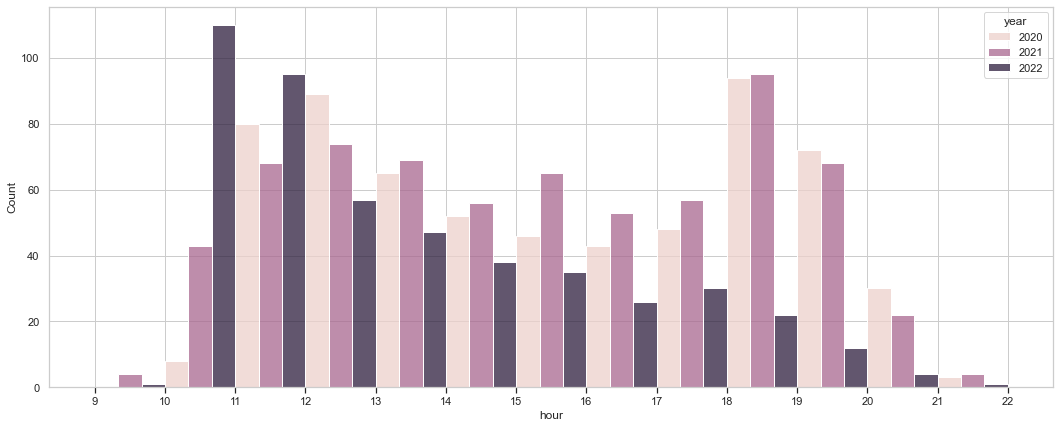

In [30]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.histplot(data=data, x='hour', bins=13, hue='year', multiple='dodge')
ax.set_xticks(data.hour.unique())
plt.show()

В 2022 году количество постов до 12:00 выросло относительно прошлых лет, а количество постов после 12:00 уменьшилось, особенно к вечеру.
Рассмотрим влияние времени публикации на активность пользователей:

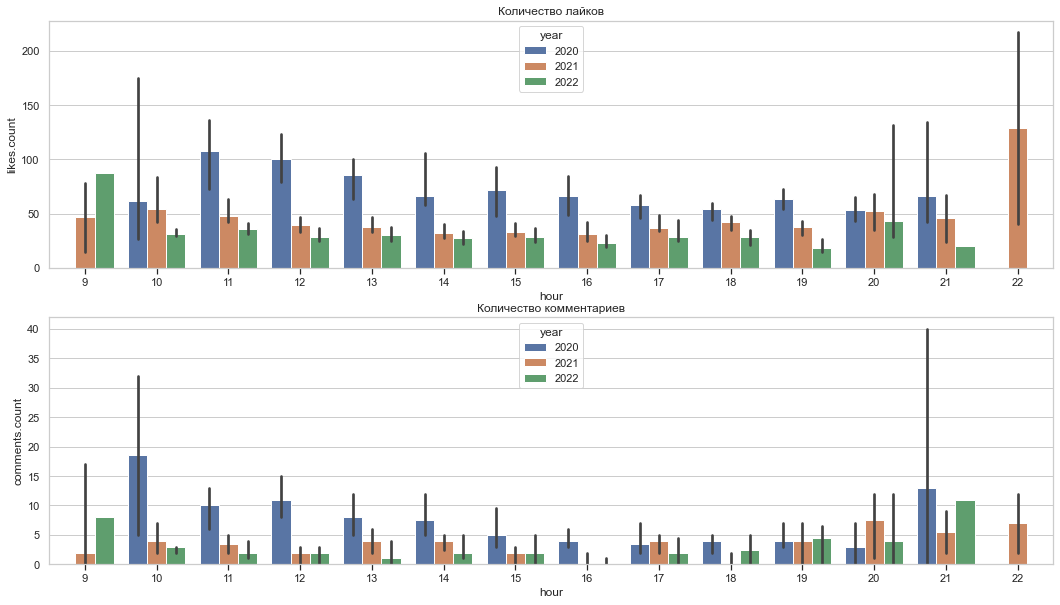

In [58]:
fig, axs = plt.subplots(nrows=2, figsize=(18, 10))
sns.barplot(data=data, x='hour', y='likes.count', hue='year', estimator=np.median, ax=axs[0])
sns.barplot(data=data, x='hour', y='comments.count', hue='year', estimator=np.median, ax=axs[1])
axs[0].set_title('Количество лайков')
axs[1].set_title('Количество комментариев')
plt.show()

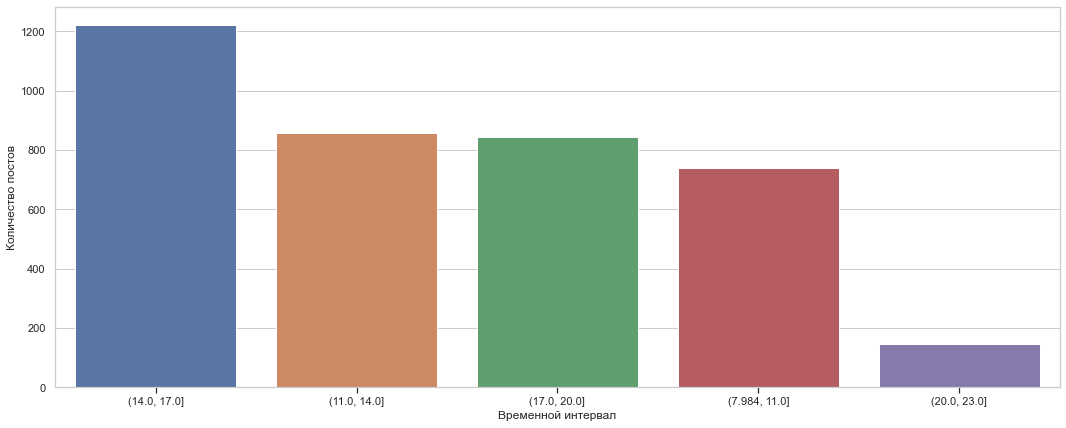

In [185]:
data['hour'].value_counts(bins=5)
intervals = data['hour'].value_counts(bins=5).rename_axis('Временной интервал').reset_index(name='Количество постов')
fig, axs = plt.subplots(figsize=(18, 7))
sns.barplot(data=intervals, x='Временной интервал', y='Количество постов')
plt.show()

## Время просмотра постов

In [213]:
posts = data.groupby('hour', as_index=False).agg('count')
activity = data.groupby('hour', as_index=False).agg('median')
activity['ratio'] = activity['likes.count'] / posts['date']
activity

,hour,views.count,likes.count,reposts.count,ratio
0,8,18185.0,73.0,10.0,73.000000
1,9,9717.0,28.0,5.0,1.866667
2,10,11607.0,32.0,6.0,0.079208
3,11,19107.5,44.5,11.0,0.139063
4,12,17988.0,46.5,10.0,0.131356
5,13,18495.5,46.0,8.0,0.156463
6,14,17617.5,35.0,7.0,0.166667
7,15,9357.0,42.0,6.0,0.074600
8,16,16893.0,37.0,8.0,0.203297
9,17,10045.0,43.0,8.0,0.090147


In [212]:
posts

,hour,date,views.count,likes.count,reposts.count
0,8,1,1,1,1
1,9,15,15,15,15
2,10,404,404,404,404
3,11,320,320,320,320
4,12,354,354,354,354
5,13,294,294,294,294
6,14,210,210,210,210
7,15,563,563,563,563
8,16,182,182,182,182
9,17,477,477,477,477


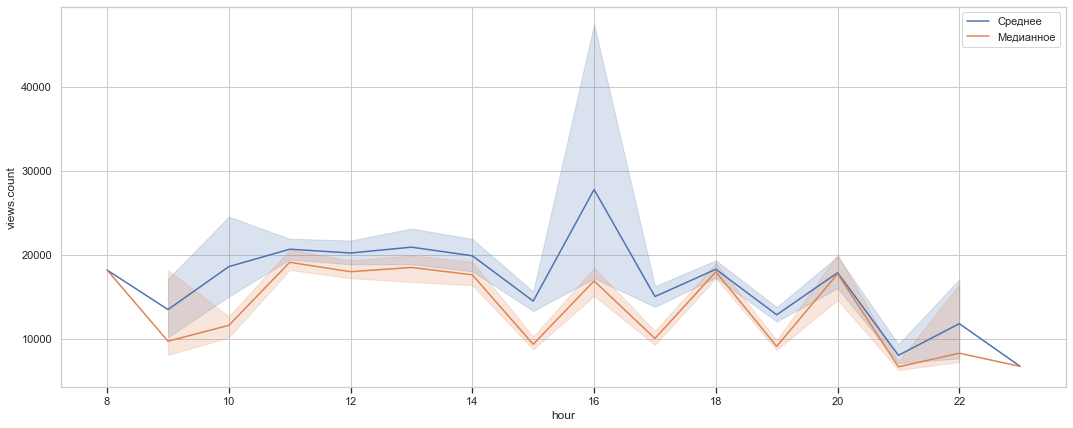

In [186]:
fig, axs = plt.subplots(figsize=(18, 7))
sns.lineplot(data=data, x='hour', y='views.count', estimator='mean', label='Среднее')
sns.lineplot(data=data, x='hour', y='views.count', estimator=np.median, label='Медианное')
plt.show()

# Отношение лайки/просмотры в зависимости от времени публикации

In [35]:
query = """
SELECT date, "views.count", "likes.count", "reposts.count",
CASE
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 8 AND 11 THEN '8-11'
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 12 AND 15 THEN '12-15'
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 16 AND 19 THEN '16-19'
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 20 AND 23 THEN '20-23'
END as interval,
CASE
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 8 AND 11 THEN 1
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 12 AND 15 THEN 2
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 16 AND 19 THEN 3
    WHEN CAST(strftime('%H', date) AS INTEGER) BETWEEN 20 AND 23 THEN 4
END as interval_number,
CAST(strftime('%H', date) AS INTEGER) as hour
FROM posts
WHERE date > DATE('2020-01-01')
"""

data = pd.read_sql(query, conn, parse_dates=['date'])
data['l/v_ratio'] = data['likes.count'] / data['views.count']
data

,date,views.count,likes.count,reposts.count,interval,interval_number,hour,l/v_ratio
0,2022-12-16 19:00:19,13954,43,14,16-19,3,19,0.003082
1,2023-01-04 12:30:00,9666,20,17,12-15,2,12,0.002069
2,2023-01-03 11:50:51,25838,82,36,8-11,1,11,0.003174
3,2023-01-02 12:05:00,26249,39,23,12-15,2,12,0.001486
4,2022-12-31 12:00:03,18456,37,3,12-15,2,12,0.002005
...,...,...,...,...,...,...,...,...
1784,2020-01-08 12:10:27,17846,26,0,12-15,2,12,0.001457
1785,2020-01-06 19:00:29,20087,116,14,16-19,3,19,0.005775
1786,2020-01-06 13:42:49,57374,368,67,12-15,2,13,0.006414
1787,2020-01-04 11:30:42,38255,100,4,8-11,1,11,0.002614


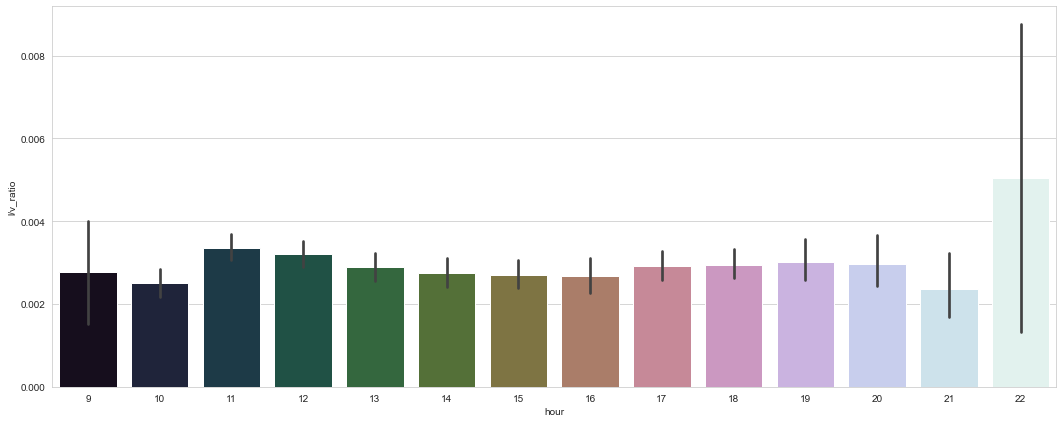

In [37]:
fig, axs = plt.subplots(figsize=(18, 7))
sns.barplot(data=data, x='hour', y='l/v_ratio', )
plt.show()

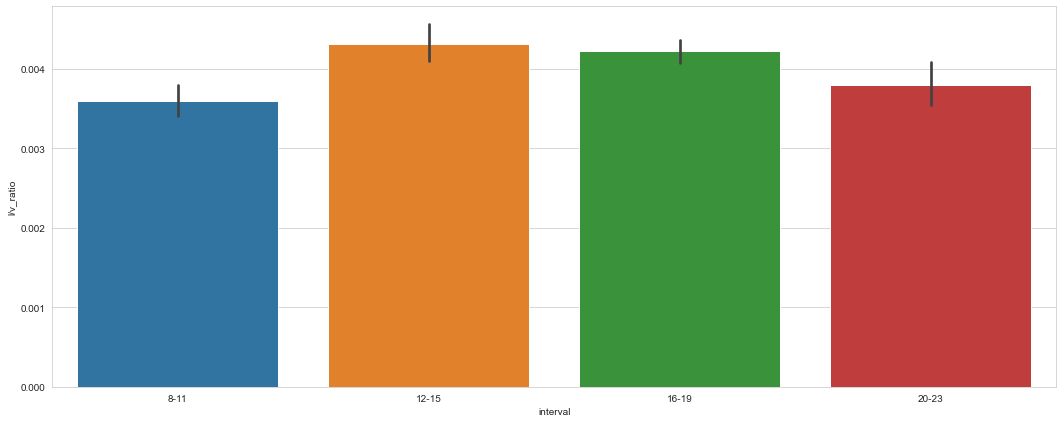

In [30]:
fig, axs = plt.subplots(figsize=(18, 7))
sns.barplot(data=data, x='interval', y='l/v_ratio', order=['8-11', '12-15', '16-19', '20-23'])
plt.show()